**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***

# Part I: Agents

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [guides/agents_guide.ipynb](guides/agents_guide.ipynb)


***
<br>

* Remember to include some reflections on your results. Are there, for example, any hyperparameters that are particularly important?

* You should follow the steps given in the `agents_guide` notebook to create your own RAG system.

<br>

***

### Set Up

In [21]:
# langgraph/langchain libraries
from langgraph.prebuilt import create_react_agent
from langchain_ibm import ChatWatsonx
from langchain_ibm import WatsonxEmbeddings
from langchain_chroma import Chroma
from langchain_core.tools import tool
from langchain.tools.retriever import create_retriever_tool
from langchain_community.tools import DuckDuckGoSearchResults

# misc libraries
import requests
from decouple import config

In [22]:
import json

json_file_path = "/Users/henrikjacobsen/Desktop/CBS/Semester 2/Artifical Intelligence and Machine Learning/apikey.json"

with open(json_file_path, "r") as file:
    data = json.load(file)

WX_API_KEY = data.get("apikey")

if WX_API_KEY:
    print("API Key loaded successfully!")
else:
    print("Error: API Key not found in JSON file.")

WX_PROJECT_ID = "0a2386df-d12c-40ee-bda2-190a5c6cc1fd"
WX_API_URL = "https://us-south.ml.cloud.ibm.com"

API Key loaded successfully!


In [23]:
chat_model = ChatWatsonx(
    url=WX_API_URL,
    apikey=WX_API_KEY,
    project_id=WX_PROJECT_ID,
    model_id="mistralai/mistral-large",
)

### Agent Architecture 

In [24]:
@tool
def add(a: float, b: float) -> float:
    """Add a and b."""
    return a + b

@tool
def subtract(a: float, b: float) -> float:
    """Subtract a and b."""
    return a - b

@tool
def multiply(a: float, b: float) -> float:
    """Multiply a and b."""
    return a * b

@tool
def divide(a: float, b: float) -> float:
    """Divide a and b."""
    return a / b

# and to make it a little more interesting, let's add a currency converter
@tool
def get_exchange_rate(
    currency_from: str = "USD",
    currency_to: str = "EUR",
    currency_date: str = "latest",
):
    """Retrieves the exchange rate between two currencies on a specified date.

    Uses the Frankfurter API (https://api.frankfurter.app/) to obtain
    exchange rate data.

    Args:
        currency_from: The base currency (3-letter currency code).
            Defaults to "USD" (US Dollar).
        currency_to: The target currency (3-letter currency code).
            Defaults to "EUR" (Euro).
        currency_date: The date for which to retrieve the exchange rate.
            Defaults to "latest" for the most recent exchange rate data.
            Can be specified in YYYY-MM-DD format for historical rates.

    Returns:
        dict: A dictionary containing the exchange rate information.
            Example: {"amount": 1.0, "base": "USD", "date": "2023-11-24",
                "rates": {"EUR": 0.95534}}
    """
    response = requests.get(
        f"https://api.frankfurter.app/{currency_date}",
        params={"from": currency_from, "to": currency_to},
    )
    return response.json()


tools = [add, subtract, multiply, divide, get_exchange_rate]

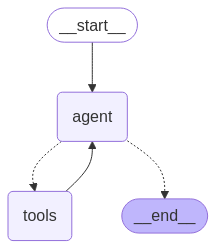

In [25]:
graph = create_react_agent(chat_model, tools=tools, debug=True)

graph

In [26]:
inputs = {
    "messages": [
        (
            "user", "I have 833 USD and my sister has 38 USD. How much do we have total in euros?"
        )
    ]
}

# we set the debug flag to True to print tasks and their results
response = graph.invoke(inputs, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'I have 833 USD and my sister has 38 USD. How much do we have '
               'total in euros?')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user',
  'I have 833 USD and my sister has 38 USD. How much do we have total in '
  'euros?')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='I have 833 USD and my sister has 38 USD. How much do we have total in euros?', additional_kwargs={}, response_metadata={}, id='e4272bff-4a19-4691-b033-da82cb176a42')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_step': False,
 'messages': [HumanMessage(content='I have 833 USD and my sister has 38 USD. How much do we have total in euros?', additional_kwargs={}, response_metadata={}, id='e4272bff-4a19-4691-b033-da82cb176a42')],
 'remaining_steps': 24}
[1:writes] Finished step 1 with wr

In [27]:
response

{'messages': [HumanMessage(content='I have 833 USD and my sister has 38 USD. How much do we have total in euros?', additional_kwargs={}, response_metadata={}, id='e4272bff-4a19-4691-b033-da82cb176a42'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '4EI46FIeB', 'type': 'function', 'function': {'name': 'add', 'arguments': '{"a": 833, "b": 38}'}}, {'id': 'o0ofwWGRi', 'type': 'function', 'function': {'name': 'get_exchange_rate', 'arguments': '{"currency_date": "latest", "currency_from": "USD", "currency_to": "EUR"}'}}]}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 627, 'total_tokens': 696}, 'model_name': 'mistralai/mistral-large', 'system_fingerprint': '', 'finish_reason': 'tool_calls'}, id='chatcmpl-993da9c41f257bcf278010c74cc69b8c', tool_calls=[{'name': 'add', 'args': {'a': 833, 'b': 38}, 'id': '4EI46FIeB', 'type': 'tool_call'}, {'name': 'get_exchange_rate', 'args': {'currency_date': 'latest', 'currency_from': 'USD', 'currency_to': 'EU

### Adding RAG

In [28]:
embed_params = {}

watsonx_embedding = WatsonxEmbeddings(
    model_id="ibm/granite-embedding-278m-multilingual",
    url=WX_API_URL,
    project_id=WX_PROJECT_ID,
    apikey=WX_API_KEY,
    params=embed_params,
)

In [29]:
vectordb = Chroma(collection_name="my_collection", persist_directory="my_vector_db", embedding_function=watsonx_embedding)

vectordb.get(limit=1)

{'ids': ['7d0c5d49-be5f-4435-8f95-b8d4f66d9e1a'],
 'embeddings': None,
 'documents': ['[About MadeUpCompany]: \nMadeUpCompany is a pioneering technology firm founded in 2010, specializing in cloud computing, data analytics, and machine learning. Headquartered in San Francisco, California, we have a global presence with satellite offices in New York, London, and Tokyo. Our mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation.  \nWith a diverse team of experts from various industries—including AI research, cybersecurity, and enterprise software development—we push the boundaries of what’s possible. Our commitment to continuous improvement, security, and customer success has earned us recognition as a leader in the tech space.'],
 'uris': None,
 'data': None,
 'metadatas': [{'Header 1': 'About MadeUpCompany'}],
 'included': [<IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [30]:
retriever_tool = create_retriever_tool(
    vectordb.as_retriever(
        search_type="similarity",
        search_kwargs={
            "k": 3,
        }
    ),
    "retrieve_company_information",
    "Search and return information about MadeUpCompany",
)

tools_for_agent = [get_exchange_rate, retriever_tool]

In [31]:
# Use the vectorstore as a retriever
retriever = vectordb.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": 3,
    }
)

retrieved_documents = retriever.invoke("Do you have a 30-day money-back guarantee?")

In [32]:
retrieved_documents

[]

In [33]:
graph = create_react_agent(chat_model, tools=tools_for_agent, debug=True)

In [34]:
response = graph.invoke(
    
    {
        "messages": [
            (
                "user", "What is CloudMate from MadeUpCompany? Keep it short and simple."
            )
        ],
    },
    debug=True,
    
)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'What is CloudMate from MadeUpCompany? Keep it short and '
               'simple.')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user', 'What is CloudMate from MadeUpCompany? Keep it short and simple.')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='What is CloudMate from MadeUpCompany? Keep it short and simple.', additional_kwargs={}, response_metadata={}, id='e9573c90-34a3-4002-ba33-25e59e000b91')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_step': False,
 'messages': [HumanMessage(content='What is CloudMate from MadeUpCompany? Keep it short and simple.', additional_kwargs={}, response_metadata={}, id='e9573c90-34a3-4002-ba33-25e59e000b91')],
 'remaining_steps': 24}
[1:writes] Finished step 1 with writes to 1 channel:
- messages -> [AIMessage(content='', add

In [35]:
response["messages"][-1].content

' CloudMate by MadeUpCompany is a comprehensive cloud management platform designed to streamline and optimize cloud resource usage. It offers features such as cost management, automated provisioning, and security compliance, ensuring businesses can efficiently manage their cloud environments.'

In [36]:
response = graph.invoke(
    
    {
        "messages": [
            (
                "user", "What is the price of CloudMate Professional? Find the price first and then convert it to euros."
            )
        ],
    },
    debug=True,
    
)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'What is the price of CloudMate Professional? Find the price '
               'first and then convert it to euros.')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user',
  'What is the price of CloudMate Professional? Find the price first and then '
  'convert it to euros.')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='What is the price of CloudMate Professional? Find the price first and then convert it to euros.', additional_kwargs={}, response_metadata={}, id='58734ef0-526f-43df-961b-64a5311eb984')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_step': False,
 'messages': [HumanMessage(content='What is the price of CloudMate Professional? Find the price first and then convert it to euros.', additional_kwargs={}, response_metadata={}, id='58734ef0-526f-43df-961b

In [37]:
print(response["messages"][-1].content)

 CloudMate Pro is available for **79 USD** per month. Based on the current exchange rate, the price in euros would be around **71.52 EUR** per month.


### Adding search tool

In [38]:
search_tool = DuckDuckGoSearchResults()

In [39]:
tools_for_agent = [get_exchange_rate, retriever_tool, search_tool]

graph = create_react_agent(chat_model, tools=tools_for_agent, debug=True)

In [40]:
response = graph.invoke(
    {
        "messages": [
            (
                "user", "Compare the price of CloudMate Professional from MadeUpCompany with the price of OneDrive from Microsoft. Find the price first and then convert it to euros."
            )
        ],
    },
    debug=True,
    
)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'Compare the price of CloudMate Professional from MadeUpCompany '
               'with the price of OneDrive from Microsoft. Find the price '
               'first and then convert it to euros.')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user',
  'Compare the price of CloudMate Professional from MadeUpCompany with the '
  'price of OneDrive from Microsoft. Find the price first and then convert it '
  'to euros.')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Compare the price of CloudMate Professional from MadeUpCompany with the price of OneDrive from Microsoft. Find the price first and then convert it to euros.', additional_kwargs={}, response_metadata={}, id='54dab446-2fca-4900-82ea-21d0120f310b')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_step': False,

In [41]:
response["messages"][-1].content

' The different OneDrive plans and their features, storage, and prices provided by Microsoft.\n| Office plan | Cost per user per month |\n| --- | --- |\n| Individual Product Plans | |\n| Microsoft 365 Personal | 6.99 us$ |\n| Microsoft 365 Family | 9.99 |\n| Business Product Plans | |\n| Microsoft OneDrive for Business Plan 1 | 5.00 us$ |\n| Microsoft OneDrive for Business Plan 2 | 10.00 us$ |\n\nCloudMate Professional by MadeUpCompany: Priced at 15 USD per user per month, this professional plan offers features tailored for businesses, including advanced collaboration tools, enhanced security measures, and substantial storage capacity (1 TB). It also integrates seamlessly with other MadeUpCompany applications for a streamlined workflow.\n\nConverting the prices:\n- Microsoft OneDrive for Business Plan 1: 5.00 USD -> Need to convert to EUR\n- Microsoft OneDrive for Business Plan 2: 10.00 USD -> Need to convert to EUR\n- CloudMate Professional: 15 USD -> Need to convert to EUR\n\nPlease 